In [336]:
import numpy as np 
import psycopg2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#Credentials for DB
host="database-dalmia.cms6cet2hwec.ap-south-1.rds.amazonaws.com"
database="dalmia_digital"
user="postgres"
password="dalmia123"
sql_query =  "SELECT * FROM dalmia_sales.sales_data where billing_date > '2020-04-01' and sold_to_party_code between 7000000 and 7099999"


class DB_Data:
    
    def __init__(self, host, database, user, password, sql_query):
        self.host = host
        self.database = database
        self.user = user
        self.password = password
        self.sql_query = sql_query
        
#Database connection funtion        
    def db_data(self):
        conn = psycopg2.connect(
            host=self.host,
            database=self.database,
            user=self.user,
            password=self.password
        )
        sql_query = self.sql_query
        df = pd.read_sql_query(sql_query, conn)
        conn.close()
        return df

#Function to create date columns 
    def create_date_columns(self):
        df = self.db_data()
        new_df = pd.DataFrame()
        for df_item in [df]:
            df_item['date'] = pd.to_datetime(df_item['billing_date'])
            df_item['Month_Year'] = pd.to_datetime(df_item['date']).dt.strftime('%Y-%m')
            df_item['Year'] = pd.to_datetime(df_item['date']).dt.year
            df_item['Quarter'] = df_item['date'].dt.to_period('Q')
            new_df = pd.concat([new_df, df_item], axis=0)
        return new_df

#Pivot data creation for 
    def pivot_data(self):
        df = self.create_date_columns()
        df_sales = df[['sold_to_party_code', 'Month_Year', 'bill_quantity']]
        df_group_month = df_sales.groupby(['sold_to_party_code', 'Month_Year']).agg({'bill_quantity': 'sum'}).reset_index()
        df_group_month.columns = ['Sold To Party Code', 'Month Year', 'Sum']
        pivot_table = pd.pivot_table(df_group_month, values='Sum', columns='Month Year', index='Sold To Party Code')
        pivot_table = pivot_table.fillna(0)
        return pivot_table
    
#New Dealers    
    def count_zeros_before_first_nonzero(self , row):
        count = 0
        for value in row:
            if value == 0:
                count += 1
            else:
                break 
        return count

#Result_matrix creation
    def count_trailing_zeros_before_end_index(self, df, end_index):
        counts = []
        for row in df.itertuples(index=False):
            count = 0
            for i in range(end_index - 1, -1, -1):
                if row[i] == 0:
                    count += 1
                else:
                    break
            counts.append(count)
        return counts

    def create_result_matrix(self):
        df = self.pivot_data()
        df['month_new_dealer'] = df.apply(self.count_zeros_before_first_nonzero,axis =1)
        df = df[df['month_new_dealer']<=14]
        result_matrix = pd.DataFrame(index=df.index)
        for i in range(len(df.columns)):
            string = str(i)
            result_matrix[string] = self.count_trailing_zeros_before_end_index(df, i)
        result_matrix.drop('0', axis=1, inplace=True)
        return df , result_matrix
    
    def inactive(self , value):
        if value == 0: 
            return 'Active'
        elif value == 1: 
            return 'Active_1N'
        elif value == 2: 
            return 'Active_2N'
        elif value == 3: 
            return 'Active_3N'
        elif value>3 and value <=12:
            return 'Inactive'
        else: 
            return 'Churn'
        
#Activity Matrix      
    def state_matrix(self):
        df, result_matrix = self.create_result_matrix()
        for i in result_matrix.columns:
            result_matrix[i] = result_matrix[i].apply(self.inactive)
        result_matrix['month_new_dealer'] = df['month_new_dealer']
        for i in result_matrix.index:
            value = df.loc[i,'month_new_dealer'] 
            result_matrix.loc[i, :value] = '-'
        result_matrix.columns = df.columns
        df.drop('month_new_dealer', axis = 1 , inplace = True)
        result_matrix.drop('month_new_dealer', axis = 1 , inplace = True)
        return df, result_matrix



In [337]:
instance = DB_Data(host, database, user, password, sql_query)
pivot, result_matrix = instance.state_matrix()

In [3]:
inactive_result = pd.read_csv('predicted_churn_2023_09-01 (1).csv')

NameError: name 'pd' is not defined

In [14]:
a = pivot[pivot.index.isin(inactive_result['dealerId'])]

In [26]:
test = result_matrix[result_matrix.index.isin(a.index)]
test[test['2023-08']=='Active'].to_csv('result_active.csv')

In [116]:
#result_matrix[result_matrix.index.isin(a.index)].to_csv('status.csv')  

In [338]:
pivot_prev = pd.read_csv('previous_year_data.csv')

In [339]:
pivot_prev.index = pivot_prev['Sold To Party Code']
pivot_prev.drop('Sold To Party Code', axis = 1 , inplace = True)

In [340]:
pivot_1 = pivot_prev.merge(pivot , left_index = True , right_index=True , how = 'right')

In [341]:
pivot_1 = pivot_1.fillna(0)

In [342]:
discount_df = pd.read_csv('data/discount_pivot.csv')
pd_df = pd.read_csv('data/pd_pivot.csv')
discount_df.index = discount_df['Sold To Party Code']
pd_df.index = pd_df['Sold To Party Code']
discount_df.drop('Sold To Party Code', axis = 1 , inplace =True)
pd_df.drop('Sold To Party Code', axis = 1 , inplace =True)

In [343]:
discount_df['avg_discount'] = discount_df.mean(axis = 1)
pd_df['avg_pd'] = pd_df.mean(axis = 1)

In [344]:
from sklearn.preprocessing import LabelEncoder
class Train:
    
    def __init__(self):
        # Create an instance of the DB_Data class with appropriate parameters
        self.db_data_instance = DB_Data(host, database, user, password, sql_query)

#training data 
    def train_data(self, pivot,result_matrix):
        cols = list(pivot.columns)
        col_inv = cols[::-1]
        df_inv = pivot[col_inv]
        
        # Call the count_zeros_before_first_nonzero function from the DB_Data instance
        df_inv['zero_count'] = df_inv.apply(self.db_data_instance.count_zeros_before_first_nonzero, axis=1)
        df_inv = df_inv[df_inv['zero_count'] <= 12]
        #target variable for the training data 
        result_matrix = result_matrix[result_matrix.index.isin(df_inv.index)]
    
        result_matrix_2 = result_matrix.drop([ '2023-04', '2023-05', '2023-06', '2023-07', '2023-08'],axis = 1)
        result_matrix_2 = result_matrix_2[list(result_matrix_2.columns)[::-1]]
        result_matrix['zero_count'] = df_inv['zero_count']
        print(result_matrix_2.shape)
        print(df_inv.shape)
        test = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'], index=df_inv.index)
        
        result_1 = pd.DataFrame(columns=['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12'], index=df_inv.index)
        
        #rolling window data for training
        for i in range(len(df_inv.index)):
            value = df_inv.iloc[i, -1]
            test.iloc[i, :] = df_inv.iloc[i, value:value+24]
            result_1.iloc[i,:] = result_matrix_2.iloc[i, value:value+12]
            
       
        y = pd.DataFrame(columns = ['state_m','state_m+1','m+2'], index = result_matrix.index)
        for i in range(result_matrix.shape[0]):
            value = df_inv.iloc[i , -1]
            #print(i)
            y.iloc[i,] = result_matrix.iloc[i , 28-value-4:28-value-1]     
        return test,y, result_1


    def data(self , test, result_1):
        df = pd.DataFrame()
        df[['m-1','m-2','m-3']]=test[['m-1','m-2','m-3']]
        df['m-1_yoy'] = test['m-1']-test['m-13']
        df['m-2_yoy'] = test['m-2']-test['m-14']
        df['m-3_yoy'] = test['m-3']-test['m-15']
        df['m-1_hy'] = test['m-1']-test['m-7']
        df['m-2_hy'] = test['m-2']-test['m-8']
        df['m-3_hy'] = test['m-3']-test['m-9']
        df['m-1_qoq'] = test['m-1']-test['m-4']
        df['m-2_qoq'] = test['m-2']-test['m-5']
        df['m-3_qoq'] = test['m-3']-test['m-6']
        test['avg_sales'] = test.mean(axis = 1)
        df = df.merge(test['avg_sales'], left_index = True , right_index = True , how = 'inner')
        status_columns = result_1.columns[1:]  # Exclude the "Identifier" column
        for index, row in result_1.iterrows():
            row_counts = row[status_columns].value_counts()
            for status_col, count in row_counts.items():
                result_1.at[index, f"{status_col}_count"] = count
        result_1 = result_1[['Active_1N_count','Active_2N_count','Active_3N_count','Inactive_count']]
        result_1 = result_1.fillna(0)
        df = df.merge(result_1, left_index = True , right_index=True , how = 'inner')
        
        return df
    
    def discount_pd(self, df , discount_df , pd_df):
        df = df.merge(discount_df['avg_discount'], left_index= True , right_index = True,
                     how = 'inner').merge(pd_df['avg_pd'], left_index = True , right_index = True, how = 'inner')
        return df
    
    def district(self , df , distt_df, region_df):
        df = df.merge(distt_df['sold_to_party_district_name'], left_index = True , 
                      right_index = True , how = 'inner').merge(region_df['sales_region'] , left_index = True , 
                                                                right_index = True , how = 'inner')
        le = LabelEncoder()
        df['sold_to_party_district_name'] = le.fit_transform( df['sold_to_party_district_name'])
        df['sales_region'] = le.fit_transform( df['sales_region'])
        return df
        
        
        


        

In [345]:
pivot_2 = pivot_1.drop([ '2023-04', '2023-05', '2023-06', '2023-07', '2023-08'],axis = 1)
result_matrix_2 = result_matrix.drop([ '2023-06', '2023-07', '2023-08'],axis = 1)

In [346]:
result_matrix_2

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Active
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn,Churn,Churn,Churn
7000022,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036703,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active_1N,Active,Active_1N,Active_2N,Active,Active_1N,Active_2N,Active
7036710,-,-,-,-,-,-,-,-,-,-,...,Active_2N,Active_3N,Active,Active_1N,Active,Active,Active,Active,Active,Active
7036715,-,-,-,-,-,-,-,-,-,-,...,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Active,Active,Active,Active


In [439]:
instance_2 = Train()
test , y , result_1= instance_2.train_data(pivot_2,result_matrix)

(10216, 24)
(10216, 37)


In [440]:
train_df = instance_2.data(test , result_1)

In [441]:
train_df = instance_2.discount_pd(train_df , discount_df , pd_df)

In [442]:
distt_df = pd.read_csv('data/unique_districts.csv')
region_df = pd.read_csv('data/unique_region.csv')

In [443]:
distt_df.index = distt_df['sold_to_party_code']
region_df.index = region_df['sold_to_party_code']

In [444]:
train_df = instance_2.district(train_df , distt_df, region_df)

In [445]:
train_df

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,m-3_qoq,avg_sales,Active_1N_count,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region
7000004,155.0,90.0,75.0,114.0,28.0,22.0,135.0,70.0,53.0,32.5,...,55.0,78.416667,0.0,0.0,0.0,0.0,45418.857333,11649.441979,24,1
7000010,12.0,33.8,0.0,-18.0,9.8,0.0,-13.0,9.8,-25.0,-5.0,...,0.0,26.450000,3.0,0.0,0.0,0.0,7740.108333,3348.170833,49,1
7000015,27.0,74.0,45.0,-50.0,3.5,-23.5,-48.5,47.0,-25.5,-27.5,...,-55.0,60.012500,0.0,0.0,0.0,0.0,26527.502527,8735.627813,235,1
7000022,29.0,0.0,24.0,29.0,0.0,24.0,5.0,-12.0,12.0,8.0,...,2.0,6.479167,1.0,0.0,0.0,0.0,2464.193442,768.258854,144,1
7000025,173.0,137.0,167.0,33.0,83.0,82.0,78.0,62.0,-8.0,100.0,...,119.0,105.991667,0.0,0.0,0.0,0.0,75982.741238,18881.577500,235,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036703,20.0,0.0,0.0,20.0,0.0,0.0,-36.25,-54.0,-30.0,4.25,...,-41.75,9.072917,2.0,1.0,0.0,0.0,3820.821825,1317.477500,329,1
7036710,64.0,58.0,61.5,64.0,58.0,61.5,64.0,58.0,61.5,6.0,...,31.5,12.562500,2.0,1.0,1.0,0.0,6411.474833,1332.979167,127,1
7036715,17.5,10.0,0.0,17.5,10.0,0.0,17.5,10.0,-20.0,17.5,...,0.0,2.395833,1.0,1.0,1.0,3.0,858.268775,501.332500,267,1
7036726,326.5,240.5,207.5,326.5,240.5,207.5,236.5,203.0,170.0,155.0,...,113.0,54.766667,0.0,0.0,0.0,0.0,34550.745833,6918.196667,23,1


In [446]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib

class Training_module:
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    def train_decision_tree(self):
        model = DecisionTreeClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Decision Tree")
        self.save_model(model, "Decision_Tree") 

    def train_svm(self):
        model = SVC(probability=True,kernel='rbf',class_weight={1:2.0})
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "SVM")
        self.save_model(model, "SVM")

    def train_random_forest(self):
        model = RandomForestClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "Random Forest")
        self.save_model(model, "Random Forest")

    def train_knn(self):
        model = KNeighborsClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "K-Nearest Neighbors")
        self.save_model(model, "K-Nearest Neighbors")

    def train_xgboost(self):
        model = XGBClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost")
        self.save_model(model, "XGBoost")

    def train_xgboost_rf(self):
        model = XGBRFClassifier()
        model.fit(self.X_train, self.y_train)
        self.evaluate_model(model, "XGBoost Random Forest")
        self.save_model(model, "XGBoost Random Forest")

    def evaluate_model(self, model, model_name):
        y_pred = model.predict(self.X_test)
        y_prob = model.predict_proba(self.X_test)[:, 1]

        print(f"Classification Report for {model_name}:\n")
        print(classification_report(self.y_test, y_pred))

        print(f"Confusion Matrix for {model_name}:\n")
        print(confusion_matrix(self.y_test, y_pred))

        self.plot_roc_curve(model, model_name, y_prob)

    def plot_roc_curve(self, model, model_name, y_prob):
        n_classes = len(set(self.y))

        if n_classes == 2:
            self.plot_binary_roc_curve(model_name, self.y_test, y_prob)
        else:
            self.plot_multiclass_roc_curve(model_name, self.y_test, y_prob, n_classes)

    def plot_binary_roc_curve(self, model_name, y_test, y_prob):
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()

    def plot_multiclass_roc_curve(self, model_name, y_test, y_prob, n_classes):
        y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(8, 6))
        colors = ['darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multiclass ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
        
        
    def save_model(self, model, model_name):
        filename = f"{model_name}_model.pkl"
        joblib.dump(model, filename)

    def load_model(self, model_name):
        filename = f"{model_name}_model.pkl"
        return joblib.load(filename)
        
    def validate_saved_model(self, model_name, X_val , y_val):
        loaded_model = self.load_model(model_name)
        # You can use the loaded model for validation or inference
        y_pred = loaded_model.predict(X_val)
        y_prob = loaded_model.predict_proba(X_val)[:, 1]
        print(f"Validation Results for {model_name}:\n")
        print(classification_report(y_val, y_pred))
        print(confusion_matrix(y_val, y_pred))
        self.plot_binary_roc_curve(loaded_model, y_val, y_prob)
        return y_pred  ,y_prob


    

In [447]:
train_df.to_csv('jul_aug.csv')
y.to_csv('target_jul_aug.csv')

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [448]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(train_df)
y = y[y.index.isin(train_df.index)]
y_1 = y['state_m'].replace({'Active':0, 'Active_1N':1})
# trainer = Training_module(X, y_1)
# trainer.train_decision_tree()


Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      2265
           1       0.63      0.77      0.69       987

    accuracy                           0.79      3252
   macro avg       0.76      0.79      0.77      3252
weighted avg       0.81      0.79      0.80      3252

Confusion Matrix for SVM:

[[1817  448]
 [ 228  759]]


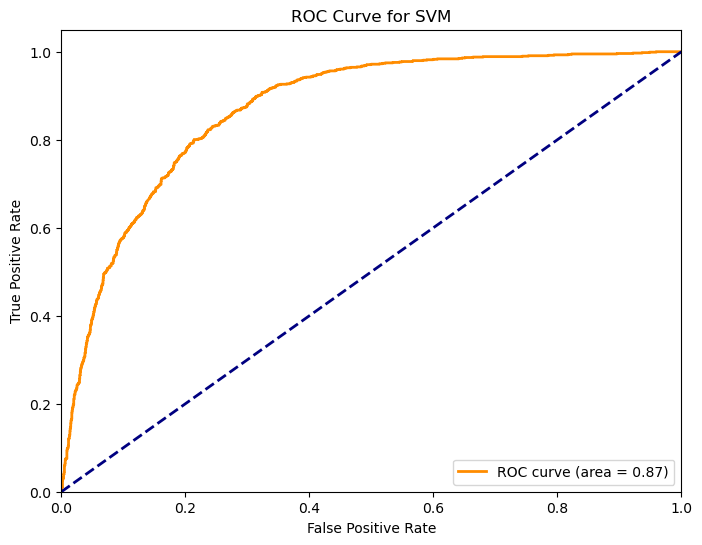

In [357]:
trainer.train_svm()

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2265
           1       0.76      0.70      0.73       987

    accuracy                           0.84      3252
   macro avg       0.82      0.80      0.81      3252
weighted avg       0.84      0.84      0.84      3252

Confusion Matrix for Random Forest:

[[2052  213]
 [ 296  691]]


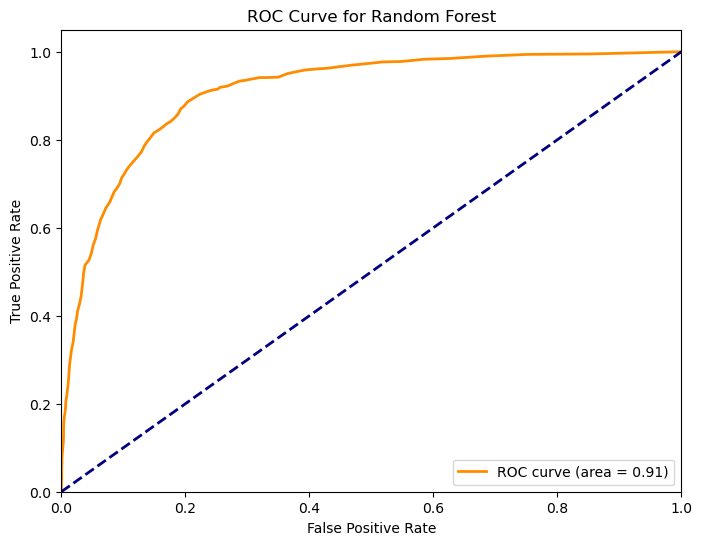

In [358]:
trainer.train_random_forest()

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      2265
           1       0.78      0.72      0.75       987

    accuracy                           0.85      3252
   macro avg       0.83      0.81      0.82      3252
weighted avg       0.85      0.85      0.85      3252

Confusion Matrix for XGBoost:

[[2062  203]
 [ 278  709]]


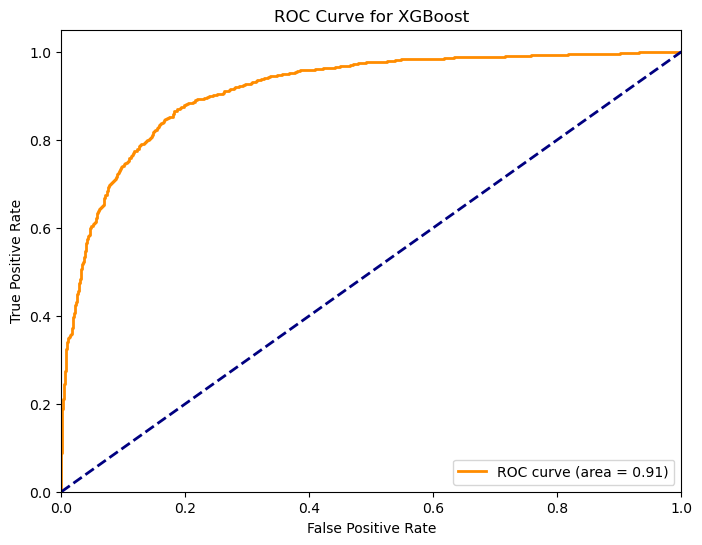

In [359]:
trainer.train_xgboost()

Classification Report for XGBoost Random Forest:

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      2265
           1       0.75      0.69      0.72       987

    accuracy                           0.84      3252
   macro avg       0.81      0.79      0.80      3252
weighted avg       0.83      0.84      0.83      3252

Confusion Matrix for XGBoost Random Forest:

[[2035  230]
 [ 305  682]]


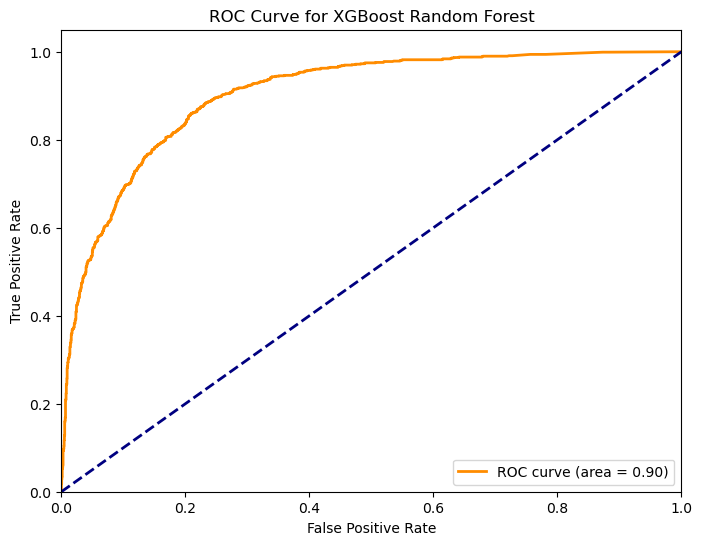

In [360]:
trainer.train_xgboost_rf()

Classification Report for K-Nearest Neighbors:

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      2265
           1       0.64      0.60      0.62       987

    accuracy                           0.78      3252
   macro avg       0.74      0.73      0.73      3252
weighted avg       0.77      0.78      0.78      3252

Confusion Matrix for K-Nearest Neighbors:

[[1939  326]
 [ 395  592]]


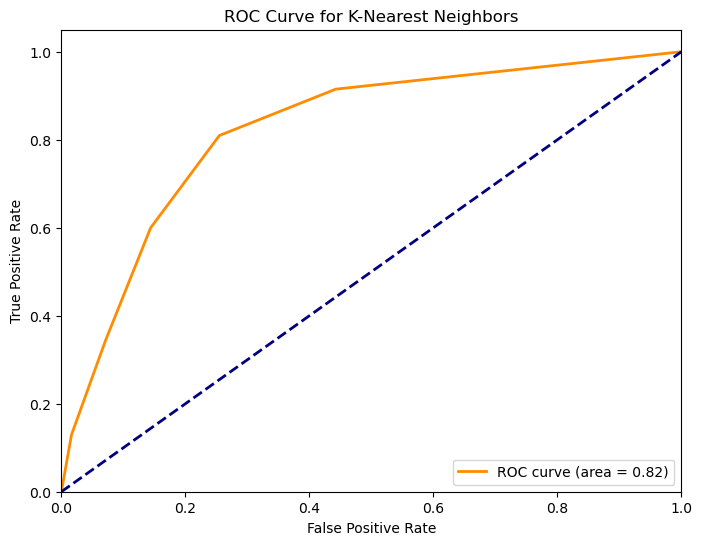

In [361]:
trainer.train_knn()

In [362]:
y['state_m+1'].value_counts()

Active       6966
Active_2N    2520
Active_1N     366
Name: state_m+1, dtype: int64

In [454]:
discount_24 = pd.read_excel('data/FY24-Discount.xlsx')

In [455]:
discount_groupby = discount_24.groupby(['Cus Code']).agg({'Total Discount':['mean'],'PD':['mean']}).reset_index()

In [456]:
discount_groupby = discount_groupby.fillna(0)
discount_groupby.columns = ['sold_to_party_code' , 'avg_discount' , 'avg_pd']

In [457]:
discount_groupby.index = discount_groupby['sold_to_party_code']

In [458]:
result_sep = result_matrix[result_matrix['2023-08']=='Active']
#result_jun = result_matrix[result_matrix['2023-06']=='Active_1N']

In [459]:
pivot_sep = pivot[pivot.index.isin(result_sep.index)]
#pivot_ = pivot[pivot.index.isin(result_sep.index)]

In [460]:
pivot_sep = pivot_sep[['2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08']]
# pivot_jun = pivot_jun[['2021-06','2021-07','2021-08', '2021-09',
#        '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
#        '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]
result_sep_1 = result_sep[['2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06','2023-07','2023-08']]
# result_jun_1 = result_jun[['2022-06','2022-07', '2022-08', '2022-09',
#        '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
#        '2023-04', '2023-05']]

In [461]:
pivot_sep.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
                                    'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
# pivot_jun.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' , 'm-13','m-14','m-15','m-16','m-17','m-18',
#                                     'm-19','m-20','m-21','m-22','m-23','m-24'][::-1]
result_sep_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
                                    'm-9', 'm-10', 'm-11', 'm-12' ][::-1]
# result_jun_1.columns = ['m-1', 'm-2', 'm-3', 'm-4', 'm-5', 'm-6', 'm-7', 'm-8', 
#                                     'm-9', 'm-10', 'm-11', 'm-12' ][::-1]

In [462]:
val_df = instance_2.data(pivot_sep, result_sep_1)

In [463]:
val_df = instance_2.discount_pd(val_df , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])

In [464]:
val_df = instance_2.district(val_df , distt_df , region_df)

In [465]:
val_df

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,m-3_qoq,avg_sales,Active_1N_count,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region
7000004,80.00,80.0,96.0,60.0,58.0,61.00,-10.00,5.0,-26.50,-31.00,...,-59.0,65.500000,0.0,0.0,0.0,0.0,26859.696000,9972.625000,25,1
7000010,13.00,24.0,12.0,1.0,-9.8,12.00,13.00,24.0,12.00,-11.00,...,12.0,12.491667,0.0,1.0,1.0,5.0,2653.938437,937.490000,51,1
7000022,24.00,12.0,12.0,12.0,0.0,9.00,24.00,-12.0,-9.00,-3.00,...,-17.0,9.604167,2.0,0.0,0.0,0.0,3309.500625,2083.333333,148,1
7000025,121.00,147.0,109.0,46.0,-28.0,-52.00,-16.00,-20.0,36.00,-11.00,...,-64.0,112.700000,0.0,0.0,0.0,0.0,51799.686500,19921.866667,234,1
7000029,90.00,90.0,55.0,30.0,60.0,-79.90,2.00,30.0,-58.00,30.00,...,-130.0,77.454167,0.0,0.0,0.0,0.0,26146.318000,12499.993333,140,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036699,13.00,0.0,12.0,0.0,-13.0,-1.00,13.00,-12.0,12.00,13.00,...,-1.0,4.791667,4.0,1.0,0.0,0.0,12817.500000,9937.500000,40,4
7036703,11.75,0.0,0.0,-44.5,-54.0,-30.00,-8.25,0.0,0.00,1.75,...,0.0,9.979167,4.0,3.0,0.0,0.0,1530.650000,3125.000000,320,1
7036710,219.00,31.0,25.0,219.0,31.0,-5.00,161.00,-30.5,-33.00,191.00,...,-39.0,26.312500,1.0,0.0,0.0,0.0,12572.241000,4484.360000,131,1
7036726,248.00,204.0,301.0,210.5,166.5,271.10,7.50,-3.5,129.50,-96.00,...,-25.5,115.308333,0.0,0.0,0.0,0.0,99918.768000,30210.925000,24,1


In [282]:
# val_july = instance_2.data(pivot_jun, result_jun_1)
# val_july = instance_2.discount_pd(val_july , discount_groupby[['avg_discount']], discount_groupby[['avg_pd']])
# val_july = instance_2.district(val_jul , distt_df , region_df)

In [283]:
val_df['state_m'] = result_jul['2023-07']


In [377]:
import joblib

# Load the model
loaded_model = joblib.load('Random Forest_model.pkl')

In [386]:
val_df_1 = sc.fit_transform(val_df)
predictions = loaded_model.predict(val_df_1)

In [421]:
val_df['predicted_rf']=predictions

In [422]:
val_df['predicted_rf'] = val_df['predicted_rf'].replace({1:'Active_1N',0:'Active'})


In [423]:
pred_proba = loaded_model.predict_proba(val_df_1)

In [424]:
val_df['pred_proba'] = pred_proba[:,1]

In [425]:
# condition = val_df['pred_proba'] < 0.60
# val_df.loc[condition, 'predicted_rf'] = 'Active'

In [426]:
val_df['predicted_rf'].value_counts()

Active       5785
Active_1N    1227
Name: predicted_rf, dtype: int64

In [428]:
val_df.to_excel('engagement.xlsx')

In [ ]:
val

In [397]:
val_df.to_excel('engagement_list.xlsx')

Validation Results for Decision_Tree:

              precision    recall  f1-score   support

           0       0.93      0.73      0.81      9143
           1       0.14      0.44      0.21       914

    accuracy                           0.70     10057
   macro avg       0.53      0.58      0.51     10057
weighted avg       0.86      0.70      0.76     10057

[[6639 2504]
 [ 511  403]]


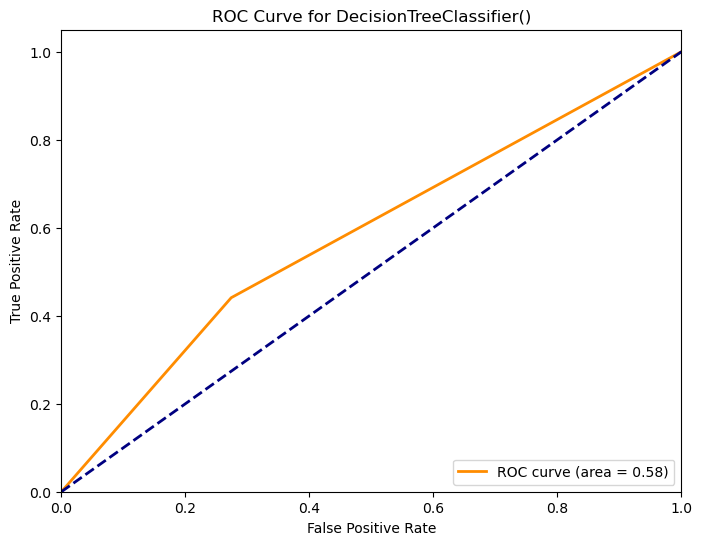

(array([1, 0, 1, ..., 1, 1, 1]), array([1., 0., 1., ..., 1., 1., 1.]))

In [286]:
from sklearn.preprocessing import StandardScaler
X_val = val_df.drop(['state_m'],axis = 1)
y_val = val_df['state_m'].replace({'Active':0,'Active_1N':1})
sc = StandardScaler()
X_val = sc.fit_transform(X_val)
trainer.validate_saved_model('Decision_Tree' , X_val , y_val)

Validation Results for Random Forest:

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      9143
           1       0.22      0.55      0.32       914

    accuracy                           0.78     10057
   macro avg       0.58      0.68      0.59     10057
weighted avg       0.88      0.78      0.82     10057

[[7359 1784]
 [ 407  507]]


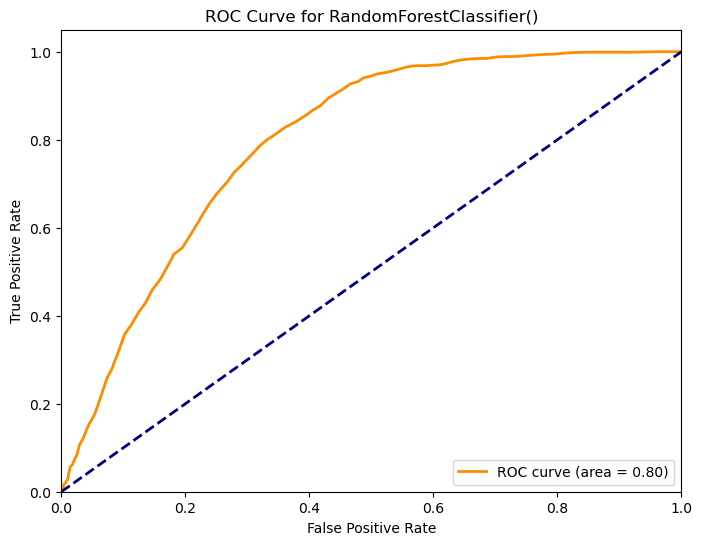

(array([0, 1, 0, ..., 1, 1, 0]),
 array([0.14, 0.65, 0.48, ..., 0.51, 0.55, 0.41]))

In [287]:
trainer.validate_saved_model('Random Forest' , X_val , y_val)

Validation Results for XGBOOST:

              precision    recall  f1-score   support

           0       0.97      0.63      0.76      9143
           1       0.18      0.80      0.29       914

    accuracy                           0.64     10057
   macro avg       0.57      0.71      0.53     10057
weighted avg       0.90      0.64      0.72     10057

[[5753 3390]
 [ 184  730]]


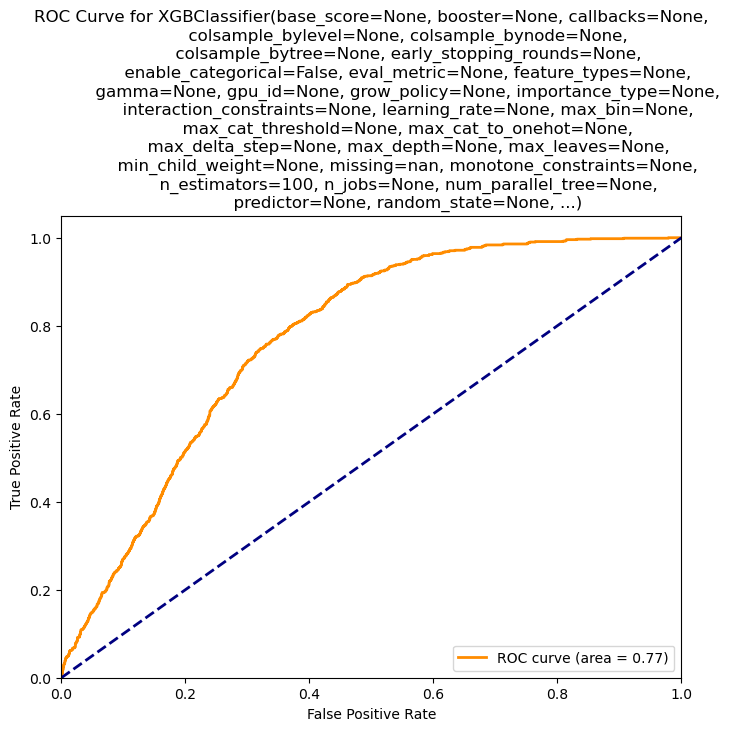

(array([0, 1, 1, ..., 1, 1, 0]),
 array([0.19067118, 0.804342  , 0.9665577 , ..., 0.89332914, 0.7171413 ,
        0.43484357], dtype=float32))

In [288]:
trainer.validate_saved_model('XGBOOST' , X_val , y_val)

Validation Results for XGBoost Random Forest:

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      9143
           1       0.24      0.67      0.36       914

    accuracy                           0.78     10057
   macro avg       0.60      0.73      0.61     10057
weighted avg       0.89      0.78      0.82     10057

[[7203 1940]
 [ 298  616]]


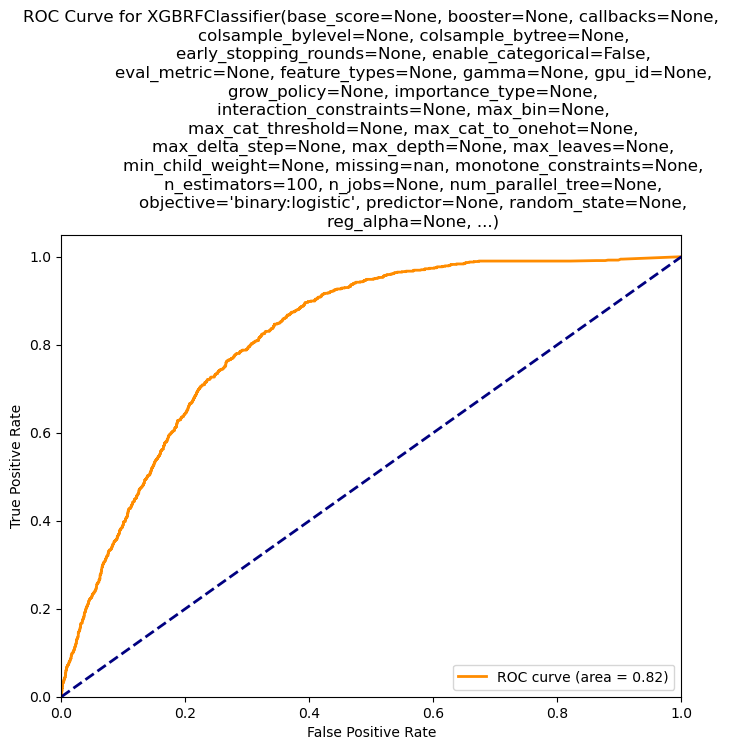

(array([0, 1, 1, ..., 0, 1, 0]),
 array([0.14182639, 0.6842772 , 0.6681975 , ..., 0.4646342 , 0.55337334,
        0.43656236], dtype=float32))

In [289]:
trainer.validate_saved_model('XGBoost Random Forest' , X_val , y_val)

Validation Results for SVM:

              precision    recall  f1-score   support

           0       0.96      0.71      0.81      9143
           1       0.19      0.71      0.31       914

    accuracy                           0.71     10057
   macro avg       0.58      0.71      0.56     10057
weighted avg       0.89      0.71      0.77     10057

[[6462 2681]
 [ 266  648]]


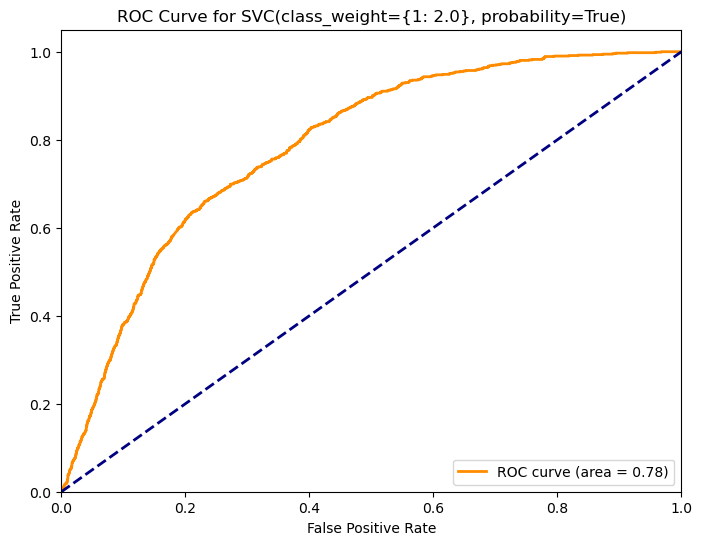

(array([0, 1, 1, ..., 0, 0, 0]),
 array([0.2596971 , 0.60833524, 0.7047677 , ..., 0.08416847, 0.11996336,
        0.30815802]))

In [290]:
trainer.validate_saved_model('SVM' , X_val , y_val)

Validation Results for K-Nearest Neighbors:

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      9143
           1       0.22      0.47      0.30       914

    accuracy                           0.80     10057
   macro avg       0.58      0.65      0.59     10057
weighted avg       0.87      0.80      0.83     10057

[[7620 1523]
 [ 486  428]]


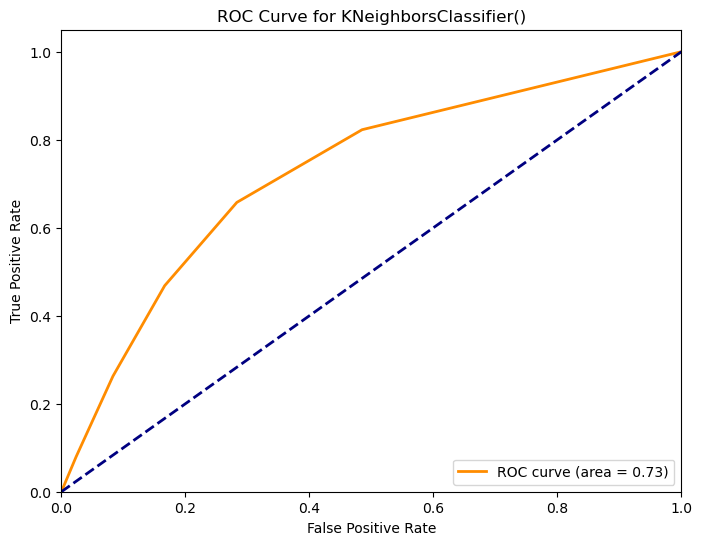

(array([0, 1, 1, ..., 0, 0, 0]), array([0. , 0.8, 0.6, ..., 0.4, 0.4, 0.2]))

In [291]:
trainer.validate_saved_model('K-Nearest Neighbors' , X_val , y_val)

Validation Results for Random Forest:

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      9143
           1       0.22      0.55      0.32       914

    accuracy                           0.78     10057
   macro avg       0.58      0.68      0.59     10057
weighted avg       0.88      0.78      0.82     10057

[[7359 1784]
 [ 407  507]]


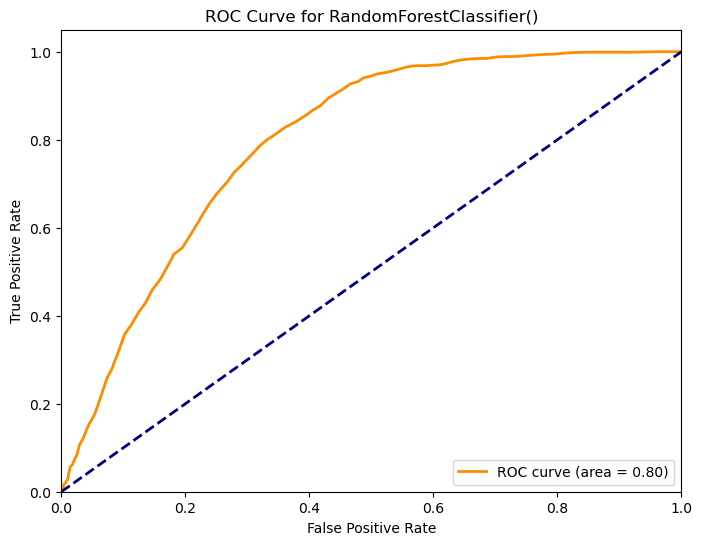

In [294]:
y_pred,y_prob = trainer.validate_saved_model('Random Forest' , X_val , y_val)

In [295]:
val_df['predicted_m'] = y_pred

In [296]:
val_df

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_1N_count,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,state_m,predicted_m
7000004,96.0,111.0,46.0,61.0,-3.0,-45.0,-26.5,91.0,26.0,-59.0,...,0.0,0.0,0.0,0.0,26859.696000,9972.625000,33,1,Active,0
7000010,12.0,24.0,0.0,12.0,7.0,-25.0,12.0,24.0,0.0,12.0,...,1.0,1.0,1.0,5.0,2653.938437,937.490000,71,1,Active,1
7000022,12.0,27.0,0.0,9.0,23.5,0.0,-9.0,22.0,-22.0,-17.0,...,2.0,0.0,0.0,0.0,3309.500625,2083.333333,190,1,Active,0
7000025,109.0,132.0,158.0,-52.0,32.0,98.0,36.0,23.2,110.0,-64.0,...,0.0,0.0,0.0,0.0,51799.686500,19921.866667,297,1,Active,0
7000029,55.0,60.0,30.0,-79.9,15.0,-30.0,-58.0,-28.0,-30.0,-130.0,...,0.0,0.0,0.0,0.0,26146.318000,12499.993333,181,1,Active,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041150,13.0,0.0,0.0,13.0,0.0,0.0,13.0,0.0,0.0,13.0,...,0.0,0.0,0.0,0.0,18979.360000,0.000000,368,0,Active,0
7041151,20.0,0.0,0.0,20.0,0.0,0.0,20.0,0.0,0.0,20.0,...,0.0,0.0,0.0,0.0,4900.000000,0.000000,233,0,Active,1
7041160,12.0,0.0,0.0,12.0,0.0,0.0,12.0,0.0,0.0,12.0,...,0.0,0.0,0.0,0.0,6000.000000,0.000000,414,5,Active,1
7041169,12.0,0.0,0.0,12.0,0.0,0.0,12.0,0.0,0.0,12.0,...,0.0,0.0,0.0,0.0,1920.000000,0.000000,277,5,Active,1


In [297]:
y_prob

array([0.14, 0.65, 0.48, ..., 0.51, 0.55, 0.41])

In [298]:
val_df['predicted_proba'] = y_prob

In [300]:
val_df['predicted_m'] = val_df['predicted_m'].replace({0:'Active',1:'Active_1N'})

In [301]:
condition = (val_df['predicted_proba'] >0.60)  
val_df.loc[condition, 'predicted'] = 'Active_1N'
# condition = (val_df['predicted_proba'] >0.40)& (val_df['m']=='Active_1N') 
# val_df.loc[condition, 'predicted'] = 'Active_1N'

In [302]:
print('Random Forest Classification Report')
print(classification_report(val_df['state_m'],val_df['predicted_m']))
print('Random Forest Confusion Matrix')
print(confusion_matrix(val_df['state_m'],val_df['predicted_m']))

Random Forest Classification Report
              precision    recall  f1-score   support

      Active       0.95      0.80      0.87      9143
   Active_1N       0.22      0.55      0.32       914

    accuracy                           0.78     10057
   macro avg       0.58      0.68      0.59     10057
weighted avg       0.88      0.78      0.82     10057

Random Forest Confusion Matrix
[[7359 1784]
 [ 407  507]]


In [475]:
small

NameError: name 'small' is not defined

In [305]:
pivot

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,joining_month
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,122.5,75.0,90.0,155.0,46.0,111.0,96.0,80.0,80.00,NaN
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.0,0.0,0.0,0.0,0.0,24.0,12.0,24.0,13.00,NaN
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,24.0,0.0,29.0,0.0,27.0,12.0,12.0,24.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.00,NaN
7041810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.65,NaN
7041815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00,NaN


In [692]:
val_df.drop(['predicted','predicted_proba'], axis = 1).to_csv('val_aug_jul.csv')

In [704]:
val_df

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,Active_2N_count,Active_3N_count,Inactive_count,avg_discount,avg_pd,sold_to_party_district_name,sales_region,m,predicted,predicted_proba
7000004,80.0,96.0,111.0,58.0,61.0,-3.0,5.0,-26.5,91.00,34.0,...,0.0,0.0,0.0,26859.696000,9972.625000,25,1,Active,Active,0.03
7000010,24.0,12.0,24.0,-9.8,12.0,7.0,24.0,12.0,24.00,24.0,...,1.0,1.0,5.0,2653.938437,937.490000,51,1,Active,Active,0.52
7000022,12.0,12.0,27.0,0.0,9.0,23.5,-12.0,-9.0,22.00,12.0,...,0.0,0.0,0.0,3309.500625,2083.333333,148,1,Active,Active_1N,0.66
7000025,147.0,109.0,132.0,-28.0,-52.0,32.0,-20.0,36.0,23.20,-11.0,...,0.0,0.0,0.0,51799.686500,19921.866667,233,1,Active,Active,0.00
7000029,90.0,55.0,60.0,60.0,-79.9,15.0,30.0,-58.0,-28.00,60.0,...,0.0,0.0,0.0,26146.318000,12499.993333,140,1,Active,Active,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036645,3.5,6.0,2.0,0.5,6.0,2.0,-3.5,0.0,-15.45,-2.5,...,0.0,0.0,0.0,3913.353333,5498.166667,157,4,Active_1N,Active_1N,0.60
7036660,25.0,25.0,50.0,0.0,25.0,50.0,-25.0,-25.0,25.00,-5.0,...,0.0,0.0,0.0,25140.420000,18880.333333,38,4,Active_1N,Active_1N,0.42
7036676,25.0,25.0,0.0,15.0,25.0,0.0,-5.0,25.0,0.00,0.0,...,2.0,1.0,1.0,27648.435000,14648.435000,154,4,Active_1N,Active_1N,0.45
7036699,12.0,0.0,0.0,-1.0,0.0,0.0,12.0,-13.0,-13.00,-1.0,...,1.0,0.0,0.0,12817.500000,9937.500000,24,4,Active_1N,Active_1N,0.45


In [812]:
dealer_size['dealer_size'].value_counts()

Medium    3194
Small     2023
Large     1731
Name: dealer_size, dtype: int64

In [816]:
prediciton_data = pd.read_csv('prediction_data.csv')

In [818]:
prediciton_data

,Unnamed: 0,m-1,m-2,m-3,m-1_qoq,m-2_qoq,m-3_qoq,m-1_hy,m-2_hy,m-3_hy,...,Active_2N_count,Active_3N_count,Inactive_count,avg_sales,actual,predicted_rf,predicted_xg,change_h2_rating,change_slope_rating,Dealer_size
0,7000004,111.00,46.0,155.0,21.00,-29.00,32.50,-11.50,26.00,135.00,...,0.0,0.0,0.0,61.375000,Active,Active,Active,High_rise,Same,Large
1,7000010,24.00,0.0,0.0,24.00,0.00,0.00,24.00,0.00,0.00,...,1.0,1.0,5.0,5.816667,Active,Active_1N,Active_1N,High_rise,Rise,Small
2,7000025,132.00,158.0,173.0,-5.00,-9.00,100.00,59.00,49.20,125.00,...,0.0,0.0,0.0,125.233333,Active,Active,Active,Rise,Same,Large
3,7000029,60.00,30.0,185.0,-28.00,-30.00,72.00,-53.00,-58.00,125.00,...,0.0,0.0,0.0,80.741667,Active,Active,Active,Same,Rise,Medium
4,7000032,460.00,424.0,959.5,-10.00,-47.00,514.50,15.00,3.00,549.50,...,0.0,0.0,0.0,478.041667,Active,Active,Active,Rise,Same,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7376,7035991,15.00,57.0,12.0,-12.50,4.20,-25.95,-22.95,31.00,-43.00,...,0.0,0.0,0.0,42.875000,Active_1N,Active,Active,High_fall,Same,Small
7377,7036151,12.45,0.0,0.0,12.45,0.00,-10.00,2.45,-9.25,-26.00,...,1.0,1.0,1.0,22.195833,Active_1N,Active_1N,Active_1N,High_fall,Same,Small
7378,7036160,46.45,0.0,150.5,-520.10,-451.00,-156.50,-260.55,-280.00,-282.75,...,0.0,0.0,0.0,402.729167,Active_1N,Active_1N,Active_1N,High_fall,Same,Large
7379,7036186,12.00,6.0,24.0,-23.00,-24.00,24.00,12.00,-8.50,0.50,...,0.0,0.0,0.0,25.041667,Active_1N,Active,Active_1N,High_fall,Same,Small


In [819]:
prediciton_data['Dealer_size'].value_counts()

Large     3535
Small     2937
Medium     909
Name: Dealer_size, dtype: int64

In [588]:
dealer_size = pd.read_csv('dealer_size_1.csv')

In [590]:
dealer_size.index = dealer_size['Unnamed: 0']

In [611]:
val_df_1 = val_df.merge(dealer_size['dealer_size'], left_index = True , right_index = True , how = 'inner')

In [612]:
pivot_2 = pivot[pivot.index.isin(val_df_1.index)]

In [613]:
pivot_2 = pivot_2[['2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07']]
pivot_2['yearly_sales'] = pivot_2.sum(axis = 1)

Month Year,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,yearly_sales
Sold To Party Code,,,,,,,,,,,,,
7000004,20.0,20.0,20.0,20.0,122.5,75.0,90.00,155.00,46.0,111.0,96.0,80.0,855.5
7000010,12.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,24.0,12.0,24.0,72.0
7000025,75.0,95.0,48.0,108.8,73.0,167.0,137.00,173.00,158.0,132.0,109.0,147.0,1422.8
7000029,60.0,60.0,60.0,88.0,113.0,60.0,88.00,185.00,30.0,60.0,55.0,90.0,949.0
7000032,405.0,435.0,410.0,421.0,445.0,471.0,470.00,959.50,424.0,460.0,495.0,517.0,5912.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036264,70.0,70.0,25.0,45.0,50.0,45.0,50.00,20.00,20.0,25.0,20.0,20.0,460.0
7036277,39.0,75.0,26.0,31.0,11.0,72.0,103.00,124.00,77.0,73.0,25.0,90.0,746.0
7036279,67.0,65.0,30.0,61.0,6.0,22.5,54.00,70.00,17.0,14.0,5.0,7.0,418.5


In [614]:
val_df_1 = val_df_1.merge(pivot_2['yearly_sales'], left_index = True , right_index=True , how = 'inner')

In [615]:
def prob(val):
    if val<=0.30:
        return 'Low'
    elif val>0.30 and val<=0.60:
        return 'Medium'
    else:
        return 'High'
val_df_1['predicted_proba'] = val_df_1['predicted_proba'].apply(prob)

In [619]:
price = pd.read_csv('price.csv')
price.index = price['Sold To Party Code']
price.drop('Sold To Party Code', axis = 1 , inplace = True)

In [621]:
price['Total_sales'] = price.sum(axis =1)
val_df_1= val_df_1.merge(price['Total_sales'] , left_index=True , right_index = True , how = 'inner')

In [622]:
val_df_1_groupby = val_df_1.groupby(['dealer_size' , 'predicted_proba']).agg({'yearly_sales':['sum','count'],'Total_sales':['sum']}).reset_index()

In [624]:
val_df_1_groupby.to_csv('matrix.csv')

In [644]:
region_df['sales_region'].value_counts()

East          6551
South         6393
Central       1258
North East    1082
West           740
NE             322
Name: sales_region, dtype: int64

In [694]:

visit_data_23 = pd.read_csv('data/pjp_fy23.csv')
visit_data_24 = pd.read_csv('data/pjp_fy24_Aug23.csv')
visit_data_23 = visit_data_23[visit_data_23['visitType']=='P']
visit_data_23 = visit_data_23[visit_data_23['visitType']=='P']

visit_data_23 = visit_data_23[(visit_data_23['sapCode']>7000000)&(visit_data_23['sapCode']<7010000)]

visit_data_24 = visit_data_24[visit_data_24['visitType']=='P']
visit_data_24 = visit_data_24[(visit_data_24['sapCode']>7000000)&(visit_data_24['sapCode']<7010000)]
visit_data_23 = visit_data_23.dropna()
visit_data = pd.concat([visit_data_23,visit_data_24], axis= 0)
visit_data_groupby = visit_data.groupby(['sapCode']).agg({'visitedBy':['count']}).reset_index()

visit_data_groupby.columns = ['Dealer_id', 'Visits']


In [698]:
visit_data_groupby.index = visit_data_groupby['Dealer_id']

In [699]:
result_matrix_visit= result_matrix.merge( visit_data_groupby['Visits'], left_index=True , right_index = True , how = 'left')

In [701]:
result_matrix_visit = result_matrix_visit[['2023-08','Visits']]

In [703]:
result_matrix_visit.to_csv('visit.csv')

In [708]:
dealer_size_group_1 = val_df_1.groupby(['dealer_size','predicted_proba','m']).agg({'m':['count']}).reset_index()

In [711]:
dealer_size_group_1.columns = ['dealer_size','predicted_probability','state','count_dealer']

In [718]:
 a = dealer_size_group_1[dealer_size_group_1['state']=='Active_1N']

In [714]:
val_df_1_groupby.columns = ['dealer_size','proba', 'sum','count','amt']

In [716]:
val_df_1_groupby['count'].sum()

6740

In [719]:
a['count_dealer'].sum()

657

In [721]:
val_df_1 = pd.read

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,avg_discount,avg_pd,sold_to_party_district_name,sales_region,m,predicted,predicted_proba,dealer_size,yearly_sales,Total_sales
7000004,80.0,96.0,111.0,58.0,61.0,-3.0,5.0,-26.5,91.0,34.00,...,26859.696000,9972.625000,25,1,Active,Active,Low,Medium,855.5,16573800.0
7000010,24.0,12.0,24.0,-9.8,12.0,7.0,24.0,12.0,24.0,24.00,...,2653.938437,937.490000,51,1,Active,Active_1N,Medium,Small,72.0,3225460.0
7000025,147.0,109.0,132.0,-28.0,-52.0,32.0,-20.0,36.0,23.2,-11.00,...,51799.686500,19921.866667,233,1,Active,Active,Low,Medium,1422.8,23351640.0
7000029,90.0,55.0,60.0,60.0,-79.9,15.0,30.0,-58.0,-28.0,60.00,...,26146.318000,12499.993333,140,1,Active,Active,Low,Medium,949.0,15217530.0
7000032,517.0,495.0,460.0,116.0,60.0,5.0,46.0,50.0,39.0,93.00,...,198668.507563,67734.286667,18,1,Active,Active,Low,Large,5912.5,95350618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036192,26.0,37.0,27.0,2.0,12.0,3.0,-24.0,25.0,15.0,-16.00,...,25093.703333,19609.436667,41,4,Active_1N,Active_1N,Medium,Small,380.0,3809200.0
7036206,57.0,36.2,20.0,2.0,16.2,-5.0,57.0,16.2,-12.0,22.00,...,37798.056667,27296.990000,8,4,Active_1N,Active,Medium,Small,265.2,3189379.0
7036220,5.0,13.0,12.0,0.0,13.0,0.0,-5.0,-4.0,7.0,-5.00,...,2028.840000,3671.860000,45,1,Active_1N,Active_1N,High,Small,77.0,751500.0
7036236,-20.0,20.0,4.5,-22.0,-2.5,-2.0,-58.0,-24.0,-20.5,-20.00,...,10408.500000,7910.220000,140,4,Active_1N,Active,Medium,Small,139.5,1436880.0


In [807]:
a.to_csv('Actual_active_1N.csv')

In [808]:
val_df_1

,m-1,m-2,m-3,m-1_yoy,m-2_yoy,m-3_yoy,m-1_hy,m-2_hy,m-3_hy,m-1_qoq,...,avg_discount,avg_pd,sold_to_party_district_name,sales_region,m,predicted,predicted_proba,dealer_size,yearly_sales,Total_sales
7000004,80.0,96.0,111.0,58.0,61.0,-3.0,5.0,-26.5,91.0,34.00,...,26859.696000,9972.625000,25,1,Active,Active,Low,Medium,855.5,16573800.0
7000010,24.0,12.0,24.0,-9.8,12.0,7.0,24.0,12.0,24.0,24.00,...,2653.938437,937.490000,51,1,Active,Active_1N,Medium,Small,72.0,3225460.0
7000025,147.0,109.0,132.0,-28.0,-52.0,32.0,-20.0,36.0,23.2,-11.00,...,51799.686500,19921.866667,233,1,Active,Active,Low,Medium,1422.8,23351640.0
7000029,90.0,55.0,60.0,60.0,-79.9,15.0,30.0,-58.0,-28.0,60.00,...,26146.318000,12499.993333,140,1,Active,Active,Low,Medium,949.0,15217530.0
7000032,517.0,495.0,460.0,116.0,60.0,5.0,46.0,50.0,39.0,93.00,...,198668.507563,67734.286667,18,1,Active,Active,Low,Large,5912.5,95350618.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036192,26.0,37.0,27.0,2.0,12.0,3.0,-24.0,25.0,15.0,-16.00,...,25093.703333,19609.436667,41,4,Active_1N,Active_1N,Medium,Small,380.0,3809200.0
7036206,57.0,36.2,20.0,2.0,16.2,-5.0,57.0,16.2,-12.0,22.00,...,37798.056667,27296.990000,8,4,Active_1N,Active,Medium,Small,265.2,3189379.0
7036220,5.0,13.0,12.0,0.0,13.0,0.0,-5.0,-4.0,7.0,-5.00,...,2028.840000,3671.860000,45,1,Active_1N,Active_1N,High,Small,77.0,751500.0
7036236,-20.0,20.0,4.5,-22.0,-2.5,-2.0,-58.0,-24.0,-20.5,-20.00,...,10408.500000,7910.220000,140,4,Active_1N,Active,Medium,Small,139.5,1436880.0


In [809]:
val_df_1.to_csv('val_df_1.csv')

In [828]:
inactive_result = pd.read_csv('predicted_churn_2023_09-01 (1).csv')

In [830]:
result_matrix[result_matrix.index.isin(inactive_result['dealerId'])]['2023-08'].value_counts()

Active_2N    212
Active_1N    112
Active         4
Name: 2023-08, dtype: int64

In [831]:
inactive_result

,dealerId,run_date
0,201035,2023-09-01
1,7000039,2023-09-01
2,7000086,2023-09-01
3,7000338,2023-09-01
4,7000421,2023-09-01
...,...,...
908,7041384,2023-09-01
909,7041406,2023-09-01
910,7041429,2023-09-01
911,7041448,2023-09-01


In [333]:
X_trend = 

,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,...,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,0.0,397.0,326.50,242.0,66.0,241.0,116.0,200.0,285.0,327.0,...,35.0,22.0,20.0,20.0,20.0,20.0,122.5,75.0,90.0,155.0
7000010,20.0,89.7,50.00,30.0,30.0,20.0,20.0,40.0,50.0,50.0,...,0.0,33.8,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000015,22.0,218.0,110.95,144.0,102.0,36.0,79.0,68.0,97.0,103.3,...,100.0,42.0,54.5,45.0,74.0,27.0,0.0,0.0,0.0,0.0
7000019,60.0,233.0,237.30,150.5,130.0,178.0,25.0,120.5,140.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000022,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,12.0,12.0,24.0,22.0,5.0,21.0,24.0,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041798,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7041810,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7041815,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [471]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest

class ModelTuner:
    def __init__(self, model, param_grid, cv=5):
        self.model = model
        self.param_grid = param_grid
        self.cv = cv
        self.best_model = None

    def tune_parameters(self, X, y):
        kfold = KFold(n_splits=self.cv, shuffle=True, random_state=42)
        scorer = make_scorer(recall_score)
        
        grid_search = GridSearchCV(self.model, self.param_grid, scoring=scorer, cv=kfold, n_jobs=-1)
        grid_search.fit(X, y)
        
        self.best_model = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)
        print("Best Accuracy:", grid_search.best_score_)

    def evaluate_best_model(self, X, y):
        if self.best_model is not None:
            y_pred = self.best_model.predict(X)
            accuracy = accuracy_score(y, y_pred)
            print("Accuracy of the Best Model:", accuracy)
        else:
            print("No best model found. Please run 'tune_parameters' first.")

# Example usage with Random Forest:
if __name__ == "__main__":
   

    param_grid = {
      
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    #'criterion': ['gini', 'entropy'],  # Criterion for splitting
    #'max_depth': [None, 10, 20, 30, 40],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
    #'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    #'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    #'class_weight': [None, 'balanced'],  # Weights associated with classes

    }

    rf_model = RandomForestClassifier()  # Use Random Forest classifier
    tuner = ModelTuner(rf_model, param_grid)
    tuner.tune_parameters(X, y_1)
    tuner.evaluate_best_model(X, y_1)

Best Parameters: {'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Accuracy: 0.7161276938470776
Accuracy of the Best Model: 0.9609216402760861


In [472]:

prediction = tuner.best_model.predict(val_df_1)

In [473]:
val_df['pred'] = prediction

In [474]:
val_df['pred'].value_counts()

0    4821
1    2191
Name: pred, dtype: int64

In [476]:
pivot.to_csv()

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,20.00,122.50,75.0,90.0,155.0,46.0,111.0,96.0,80.0,80.00
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,0.00,0.00,0.0,0.0,0.0,0.0,24.0,12.0,24.0,13.00
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,27.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.00,21.00,24.0,0.0,29.0,0.0,27.0,12.0,12.0,24.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.75,0.00,0.0,20.0,0.0,0.0,10.0,0.0,0.0,11.75
7036710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,58.00,61.5,58.0,64.0,27.0,28.0,25.0,31.0,219.00
7036715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,10.0,17.5,20.0,20.0,16.0,0.0,0.00


NameError: name 'result_matrix' is not defined

NameError: name 'pivot' is not defined